In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import warnings
import joblib

warnings.filterwarnings('ignore')

In [7]:
# ---------------------------------------------------------
# 1. LOAD & CLEAN DATA
# ---------------------------------------------------------
df = pd.read_csv('Training_Dataset.csv')

# 2. CLEANING & FEATURE ENGINEERING
# a. Wait Time -> Minutes
def to_min(x):
    try:
        parts = str(x).split(':')
        return int(parts[0])*60 + int(parts[1]) + float(parts[2])/60
    except: return 0.0
df['wait_minutes'] = df['Wait_Time'].apply(to_min)

print(df[['Wait_Time', 'wait_minutes']].head())

# b. Arrival Time -> Hour
df['hour'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M:%S', errors='coerce').dt.hour.fillna(0).astype(int)

print(df[['Arrival_Time', 'hour']].head())

# c. FIX: Day -> Logical Mapping (0=Mon, 6=Sun)
day_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['day_of_week'] = df['Day'].map(day_mapping).fillna(0).astype(int)

print(df[['Day', 'day_of_week']].head())

# d. Rename Queue
if 'Queue_Length' in df.columns:
    df.rename(columns={'Queue_Length': 'queue_length'}, inplace=True)

# Select features
features = ['queue_length', 'hour', 'day_of_week']
target = 'wait_minutes'
df_clean = df[features + [target]].dropna()

# Chia tập train/test
X = df_clean[features]
y = df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  Wait_Time  wait_minutes
0   0:00:00           0.0
1   0:00:00           0.0
2   0:00:00           0.0
3   0:02:00           2.0
4   0:02:00           2.0
  Arrival_Time  hour
0     11:01:00    11
1     11:02:00    11
2     11:04:00    11
3     11:06:00    11
4     11:08:00    11
      Day  day_of_week
0  Friday            4
1  Friday            4
2  Friday            4
3  Friday            4
4  Friday            4



--- Training & Evaluating ---
Random Forest -> R2: 0.9577, MAE: 1.09 min
XGBoost -> R2: 0.9579, MAE: 1.10 min
LightGBM -> R2: 0.9597, MAE: 1.09 min


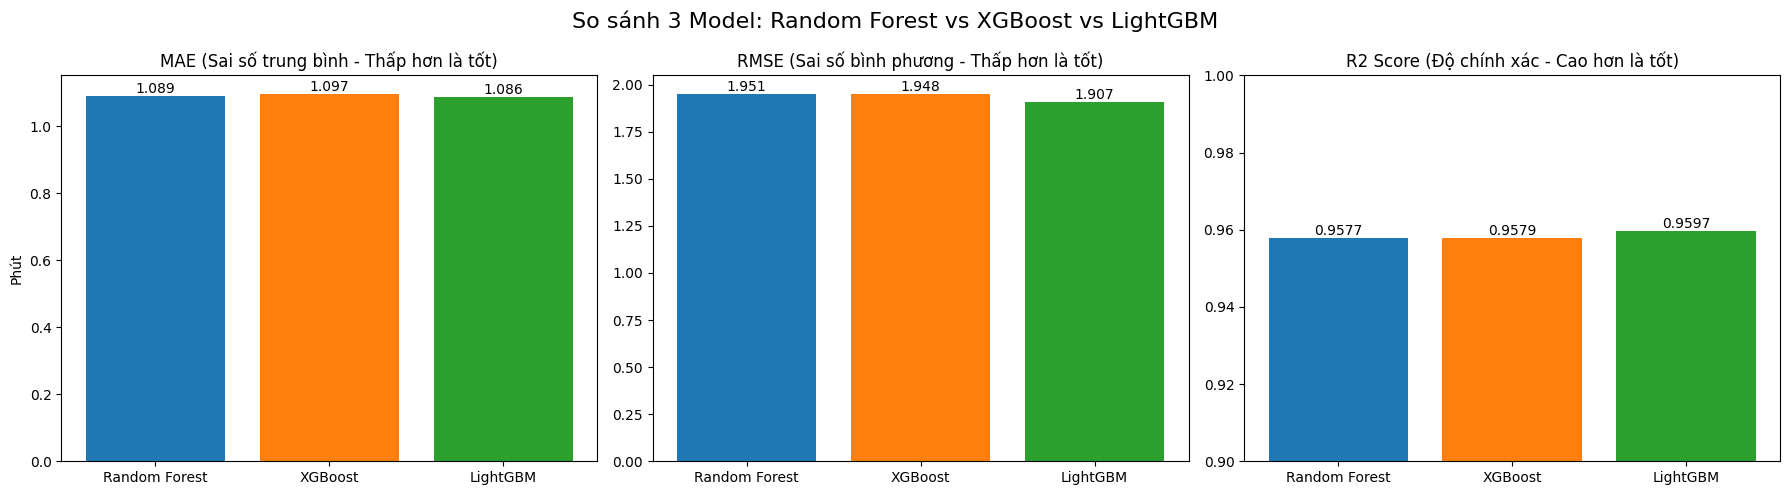


--- Bảng Tổng Hợp Kết Quả ---
           Model       MAE      RMSE        R2
0  Random Forest  1.088616  1.951377  0.957747
1        XGBoost  1.096855  1.948275  0.957881
2       LightGBM  1.085653  1.906526  0.959667


In [8]:
# ---------------------------------------------------------
# 2. TRAIN 3 MODELS
# ---------------------------------------------------------
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

results = []

print("\n--- Training & Evaluating ---")
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    print(f"{name} -> R2: {r2:.4f}, MAE: {mae:.2f} min")

# ---------------------------------------------------------
# 3. VISUALIZATION & COMPARISON
# ---------------------------------------------------------
res_df = pd.DataFrame(results)

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('So sánh 3 Model: Random Forest vs XGBoost vs LightGBM', fontsize=16)

# Biểu đồ MAE
axes[0].bar(res_df['Model'], res_df['MAE'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('MAE (Sai số trung bình - Thấp hơn là tốt)')
axes[0].set_ylabel('Phút')
for i, v in enumerate(res_df['MAE']):
    axes[0].text(i, v, f"{v:.3f}", ha='center', va='bottom')

# Biểu đồ RMSE
axes[1].bar(res_df['Model'], res_df['RMSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('RMSE (Sai số bình phương - Thấp hơn là tốt)')
for i, v in enumerate(res_df['RMSE']):
    axes[1].text(i, v, f"{v:.3f}", ha='center', va='bottom')

# Biểu đồ R2
axes[2].bar(res_df['Model'], res_df['R2'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[2].set_title('R2 Score (Độ chính xác - Cao hơn là tốt)')
axes[2].set_ylim(0.9, 1.0) # Zoom để thấy rõ sự khác biệt
for i, v in enumerate(res_df['R2']):
    axes[2].text(i, v, f"{v:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Hiển thị bảng kết quả
print("\n--- Bảng Tổng Hợp Kết Quả ---")
print(res_df)

In [9]:
# ---------------------------------------------------------
# 4. CHỌN MODEL TỐT NHẤT & LƯU (SELECT & SAVE)
# ---------------------------------------------------------
print("\n--- Đang chọn Model tốt nhất... ---")

# Sắp xếp dataframe kết quả theo R2 giảm dần (cao nhất đứng đầu)
# Bạn cũng có thể đổi thành sort_values(by='RMSE', ascending=True) nếu muốn ưu tiên sai số thấp nhất
best_result = res_df.sort_values(by='R2', ascending=False).iloc[0]

best_model_name = best_result['Model']
best_r2_score = best_result['R2']
best_model_object = models[best_model_name] # Lấy object model thực tế từ dictionary

print(f"🏆 Model chiến thắng: {best_model_name}")
print(f"📊 Độ chính xác (R2): {best_r2_score:.4f}")

# Lưu model thành file .pkl
model_filename = 'smartqueue_best_model.pkl'
joblib.dump(best_model_object, model_filename)
print(f"💾 Đã lưu model vào file: {model_filename}")


--- Đang chọn Model tốt nhất... ---
🏆 Model chiến thắng: LightGBM
📊 Độ chính xác (R2): 0.9597
💾 Đã lưu model vào file: smartqueue_best_model.pkl


In [10]:
# ---------------------------------------------------------
# 5. CREATE TEST TICKETS
# ---------------------------------------------------------
test_tickets = pd.DataFrame({
    'queue_length': [1, 3, 5, 8, 10, 12, 15, 18, 20, 25],
    'hour':         [8, 9, 10, 11, 13, 14, 15, 16, 17, 18],
    'day_of_week':  [0, 1, 2, 3, 4, 4, 5, 5, 6, 6]  # Mon → Sun
})

print("\n--- Test Tickets ---")
print(test_tickets)



--- Test Tickets ---
   queue_length  hour  day_of_week
0             1     8            0
1             3     9            1
2             5    10            2
3             8    11            3
4            10    13            4
5            12    14            4
6            15    15            5
7            18    16            5
8            20    17            6
9            25    18            6


In [11]:
# ---------------------------------------------------------
# 5. PREDICT WAITING TIME FOR TEST TICKETS
# ---------------------------------------------------------
best_model = models['LightGBM']

test_tickets['predicted_wait_minutes'] = best_model.predict(test_tickets)

print("\n--- Prediction Result ---")
print(test_tickets)



--- Prediction Result ---
   queue_length  hour  day_of_week  predicted_wait_minutes
0             1     8            0                3.215905
1             3     9            1               13.802272
2             5    10            2               20.899335
3             8    11            3               38.560677
4            10    13            4               37.692763
5            12    14            4               37.692763
6            15    15            5               37.406962
7            18    16            5               37.406962
8            20    17            6               39.444490
9            25    18            6               39.444490
